In [1]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

import boa
from l4 import display_erc20, lesson4

user = boa.env.eoa
vault, controller, amm, oracle, factory, pool, collateral_token, crvusd = lesson4()

# Approve tokens for trading
crvusd.approve(amm, 2**256 - 1)
collateral_token.approve(amm, 2**256 - 1)

# Sanity check
print(f"Number of loans in the `{controller._name}` vault: {controller.n_loans()}")


Number of loans in the `VyperWifController` vault: 1


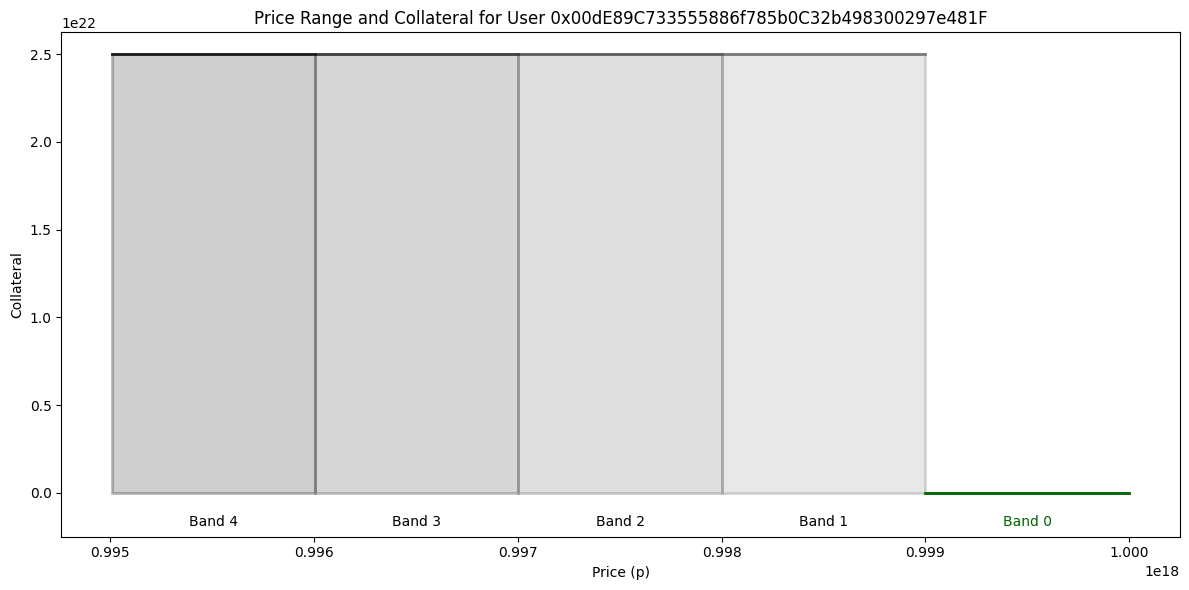

In [2]:
# Helper Functions

def user_balances(user, crvusd, collateral):
    print(f"crvUSD: {crvusd.balanceOf(user) / 10 ** 18:,.2f}")
    print(f"Collateral: {collateral.balanceOf(user) / 10 ** 18:,.2f}")

def plot(amm, user):
    bands = range(
        min(0, amm.active_band(), amm.read_user_tick_numbers(user)[0]),
        max(amm.active_band(), amm.read_user_tick_numbers(user)[1]) + 1,
    )

    p_min = [amm.p_oracle_down(n) for n in bands]
    p_max = [amm.p_oracle_up(n) for n in bands]
    y_values = [amm.bands_y(n) for n in bands]

    fig, ax = plt.subplots(figsize=(12, 6))
    grey_cmap = plt.colormaps["Greys"]

    for i, (min_val, max_val, y_val) in enumerate(zip(p_min, p_max, y_values)):
        width = max_val - min_val

        if bands[i] == amm.active_band():
            color = "green"
            edge_color = "darkgreen"
            text_color = "darkgreen"
        else:
            # Use different shades of grey for non-active bands
            color = grey_cmap(0.3 + (i / len(bands)) * 0.5)
            edge_color = grey_cmap(0.5 + (i / len(bands)) * 0.5)
            text_color = "black"

        rect = plt.Rectangle(
            (min_val, 0),
            width,
            y_val,
            fill=True,
            facecolor=color,
            alpha=0.3,
            edgecolor=edge_color,
            linewidth=2,
        )
        ax.add_patch(rect)

        # Add horizontal line for y_val = 0 cases
        ax.plot([min_val, max_val], [y_val, y_val], color=edge_color, linewidth=2)

        # Add band number label below each rectangle
        ax.text(
            (min_val + max_val) / 2,
            -max(y_values) * 0.05,
            f"Band {bands[i]}",
            ha="center",
            va="top",
            color=text_color,
        )

    ax.set_xlabel("Price (p)")
    ax.set_ylabel("Collateral")
    ax.set_title(f"Price Range and Collateral for User {user}")

    # Set y-axis limit to accommodate labels below x-axis
    ax.set_ylim(bottom=-max(y_values) * 0.1)

    plt.tight_layout()
    plt.show()


plot(amm, user)


In [3]:
# Status pre-trade
x_val = 10_000 * 10**18
y_val = amm.get_dy(0, 1, x_val)

print(f"The AMM will trade {x_val / 10 ** 18:,.0f} $crvUSD for {y_val / 10 ** 18:,.2f} collateral tokens")

The AMM will trade 10,000 $crvUSD for 9,971.04 collateral tokens


## Make a Trade

Starting Balance:
crvUSD: 98,394.42
Collateral: 89,900,000.00

Ending Balance:
crvUSD: 88,394.42
Collateral: 89,909,971.04


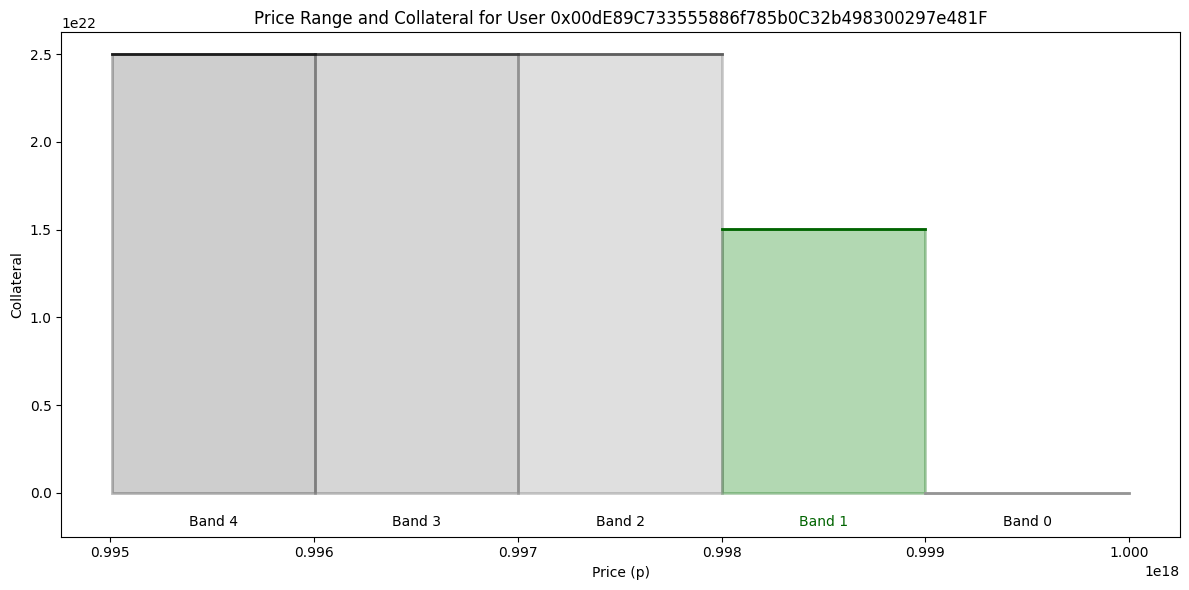

In [4]:
# Initial balances
print("Starting Balance:")
user_balances(user, crvusd, collateral_token)

# Trade
amm.exchange(0, 1, x_val, int(y_val * .999))

# Results
print("\nEnding Balance:")
user_balances(user, crvusd, collateral_token)
plot(amm, user)

## Simulate Trade Using an Anchor

The AMM will trade 25,000 $crvUSD for 24,887.93 collateral tokens
Starting Balances
crvUSD: 88,394.42
Collateral: 89,909,971.04

Ending balances
crvUSD: 63,394.42
Collateral: 89,934,858.97


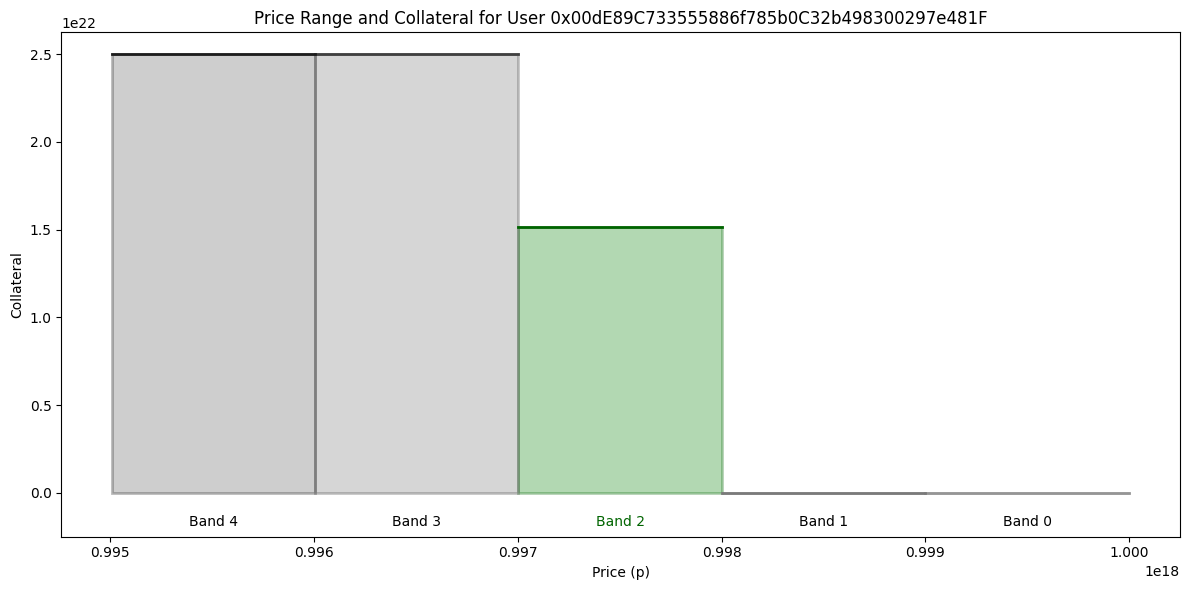

In [5]:
# Status pre-trade
x_val = 25000 * 10 ** 18
y_val = amm.get_dy(0, 1, x_val)
print(f"The AMM will trade {x_val / 10 ** 18:,.0f} $crvUSD for {y_val / 10 ** 18:,.2f} collateral tokens")

# Initial balances
print("Starting Balances")
user_balances(user, crvusd, collateral_token)

# Test a trade
with boa.env.anchor():
    amm.exchange(0, 1, x_val, int(y_val * .999))

    # Results
    print("\nEnding balances")
    user_balances(user, crvusd, collateral_token)
    plot(amm, user)

crvUSD: 88,394.42
Collateral: 89,909,971.04


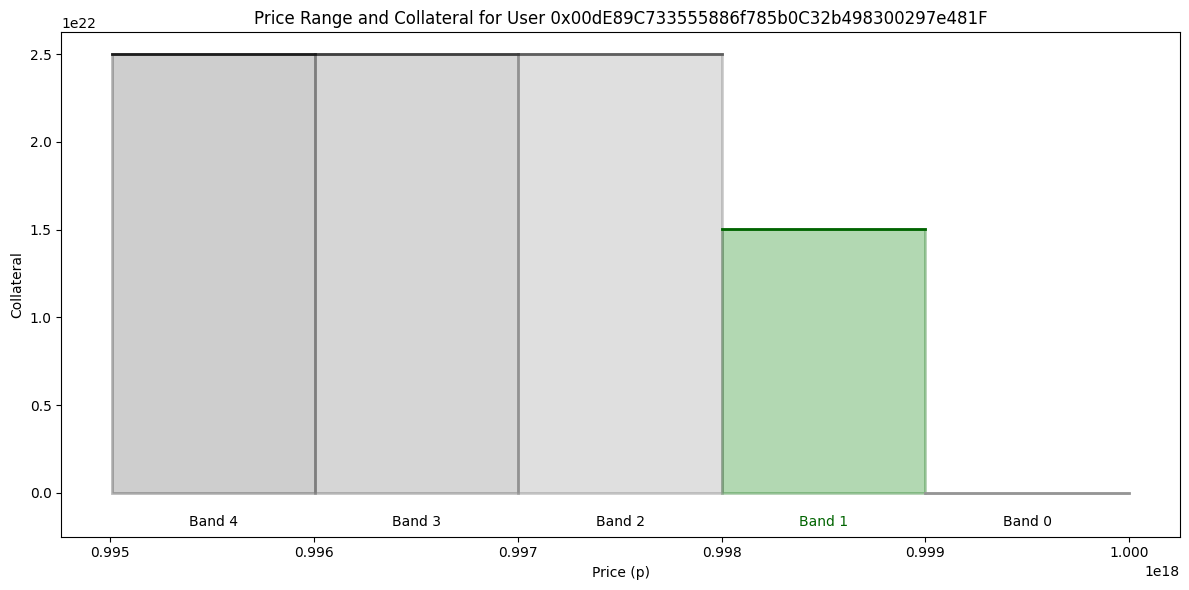

In [6]:
# It was all a dream
user_balances(user, crvusd, collateral_token)
plot(amm, user)

## Trade in Reverse

The AMM will trade 25,000 collateral tokens for 10,000.00 $crvUSD
Starting Balances
crvUSD: 88,394.42
Collateral: 89,909,971.04

Ending Balances
crvUSD: 98,394.42
Collateral: 89,899,990.02


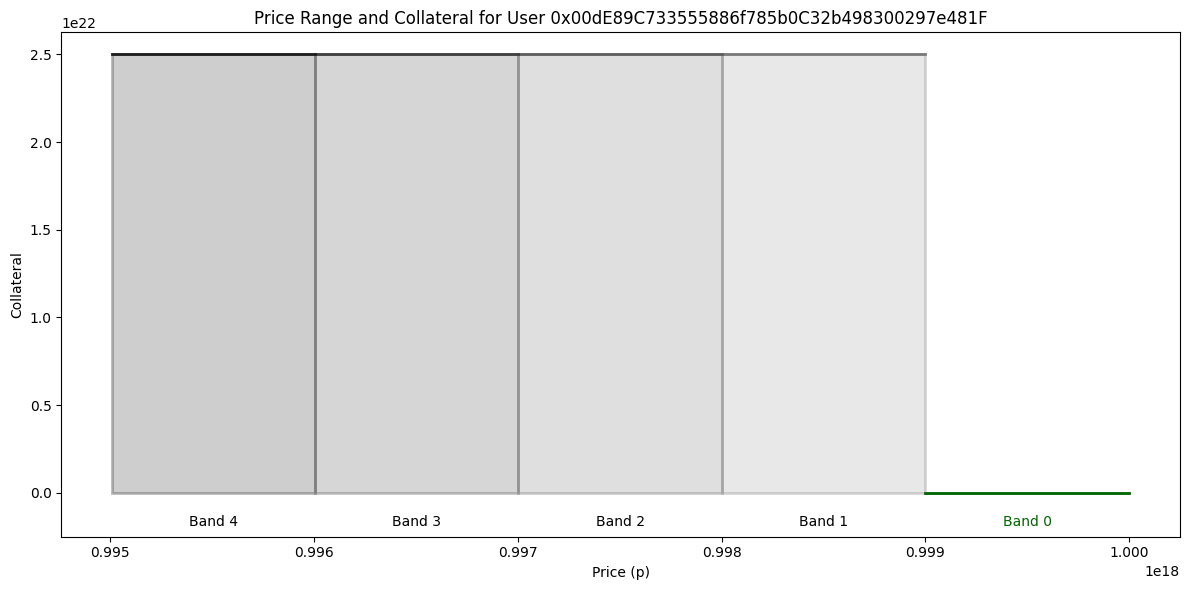

In [7]:
# Status pre-trade
x_val = 25_000 * 10 ** 18
y_val = amm.get_dy(1, 0, x_val)
print(f"The AMM will trade {x_val / 10 ** 18:,.0f} collateral tokens for {y_val / 10 ** 18:,.2f} $crvUSD")

# Initial balances
print("Starting Balances")
user_balances(user, crvusd, collateral_token)

# Trade
amm.exchange(1, 0, x_val, int(y_val * .99))

# Results
print("\nEnding Balances")
user_balances(user, crvusd, collateral_token)
plot(amm, user)